<a href="https://colab.research.google.com/github/r-siddiqi/Hofstadter/blob/main/Integrated_Kagome_Lattice_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd

In [12]:
class Kagome_Hamiltonian:
    """
    Kagome lattice simulation with Anderson localization and magnetic field.
    """

    def __init__(self, t: float, W: float, phi: float, q: int):
        """
        Initialize Kagome_Hamiltonian class.

        Parameters:
            t (float): Hopping parameter.
            W (float): Disorder parameter.
            phi (float): Magnetic flux per plaquette (in units of flux quantum).
            q (int): Denominator of the flux density (phi = p / q).
        """
        self.t = t  # Hopping parameter
        self.disorder = W  # Disorder strength
        self.phi = phi  # Magnetic flux per unit cell
        self.max_q = q  # Denominator of flux density
        self.period = 8  # Periodicity factor
        self.N = 3 * q  # Total number of sites (3 sites per magnetic unit cell)
        self.matrix = np.zeros((self.N, self.N), dtype=complex)

    def disorder_setter(self):
         # Incorporate the disorder parameter into matrix elements as an on-site disorder potential
        self.on_site_potential = self.disorder * (2 * np.random.rand(self.N) - 1)

    def construct_hamiltonian(self):
        # Construct the Hamiltonian matrix
        self.disorder_setter()
        t = self.t
        p = int(self.phi * self.q)  # Numerator of flux density
        q = self.q
        period = self.period
        nphi = p / q
        # m is a magnetic unit cell index

        # Define the block functions
        def AB_block(t, p, q):
            ham = np.zeros((q, q), dtype=complex)
            nphi = p / q

            def A(t, nphi, m):
                value = (-t * np.exp(-1j * np.pi * period * nphi * m)
                         - t * np.exp(+1j * np.pi * period * nphi * m))
                return value

            values = np.array([A(t, nphi, m) for m in range(q)])
            ham += np.diag(values)
            return ham

        def AC_block(t, p, q):
            ham = np.zeros((q, q), dtype=complex)
            nphi = p / q

            def A(t, nphi, m):
                phase = -1j * np.pi * period * nphi * 0.5 * (m + 0.25)
                return -t* np.exp(phase)

            def B_minus(t, nphi, m):
                phase = +1j * np.pi * period * nphi * 0.5 * (m - 0.25)
                return -t* np.exp(phase)

            values_A = np.array([A(t, nphi, m) for m in range(q)])
            values_B_minus = np.array([B_minus(t, nphi, m) for m in range(q)])
            ham += np.diag(values_A)
            ham += np.diag(values_B_minus[:-1], k=-1)
            ham[0, -1] = values_B_minus[-1]  # Periodic boundary condition
            return ham

        def BA_block(t, p, q):
            return AB_block(t, p, q).conj().T

        def BC_block(t, p, q):
            ham = np.zeros((q, q), dtype=complex)
            nphi = p / q

            def A(t, nphi, m):
                phase = +1j * np.pi * period * nphi * 0.5 * (m + 0.25)
                return -t * np.exp(phase)

            def B_minus(t, nphi, m):
                phase = -1j * np.pi * period * nphi * 0.5 * (m - 0.25)
                return -t * np.exp(phase)

            values_A = np.array([A(t, nphi, m) for m in range(q)])
            values_B_minus = np.array([B_minus(t, nphi, m) for m in range(q)])
            ham += np.diag(values_A)
            ham += np.diag(values_B_minus[:-1], k=-1)
            ham[0, -1] = values_B_minus[-1]  # Periodic boundary condition
            return ham

        def CA_block(t, p, q):
            ham = np.zeros((q, q), dtype=complex)
            nphi = p / q

            def A(t, nphi, m):
                phase = +1j * np.pi * period * nphi * 0.5 * (m + 0.25)
                return -t * np.exp(phase)

            def B_plus(t, nphi, m):
                phase = -1j * np.pi * period * nphi * 0.5 * (m + 0.75)
                return -t * np.exp(phase)

            values_A = np.array([A(t, nphi, m) for m in range(q)])
            values_B_plus = np.array([B_plus(t, nphi, m) for m in range(q)])
            ham += np.diag(values_A)
            ham += np.diag(values_B_plus[1:], k=1)
            ham[-1, 0] = values_B_plus[0]  # Periodic boundary condition
            return ham

        def CB_block(t, p, q):
            return BC_block(t, p, q).conj().T

        # Construct the blocks
        AA = np.diag(self.on_site_potential[:q])
        BB = np.diag(self.on_site_potential[q:2*q])
        CC = np.diag(self.on_site_potential[2*q:3*q])

        AB = AB_block(t, p, q)
        AC = AC_block(t, p, q)
        BA = BA_block(t, p, q)
        BC = BC_block(t, p, q)
        CA = CA_block(t, p, q)
        CB = CB_block(t, p, q)

        # Assemble the Hamiltonian
        upper = np.concatenate((AA, AB, AC), axis=1)
        middle = np.concatenate((BA, BB, BC), axis=1)
        lower = np.concatenate((CA, CB, CC), axis=1)
        self.H = np.concatenate((upper, middle, lower), axis=0)

        # Compute eigenvalues and eigenvectors
        self.evals, self.evecs = np.linalg.eigh(self.H)

    def plot_hofstadter_butterfly(self):
        # Plot Hofstadter butterfly
        plt.figure(figsize=(10, 8))
        phis = []
        energies = []

        for q in range(1, self.max_q + 1):
            for p in range(q + 1):
                if gcd(p, q) == 1:
                    self.q = q
                    self.phi = p / q
                    self.N = 3 * q  # Update N based on q
                    self.matrix = np.zeros((self.N, self.N), dtype=complex)
                    self.construct_hamiltonian()
                    phis.extend([self.phi] * self.N)
                    energies.extend(self.evals.tolist())

        plt.scatter(phis, energies, s=0.1, color='black')
        plt.xlabel('Flux per Plaquette $\\phi = p/q$')
        plt.ylabel('Energy $E$')
        plt.title(f'Hofstadter Butterfly for $\\phi = p / {self.max_q}$ and $W = {self.disorder}$')
        plt.grid(True)
        plt.show()


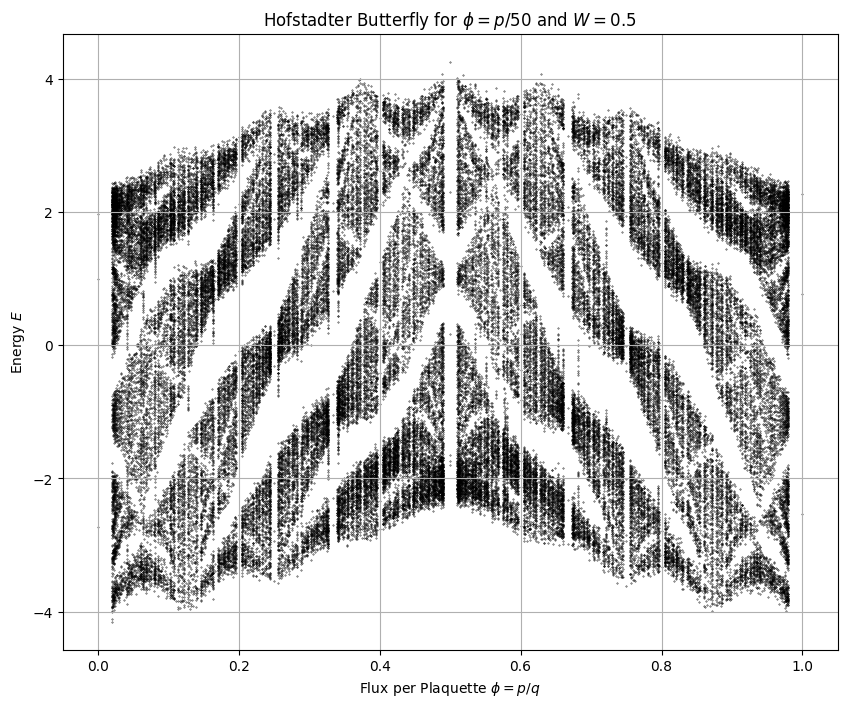

In [14]:
# Parameters
t = 1.0        # Hopping amplitude
W = 0.5        # Disorder strength
phi = 0.0      # Initial magnetic flux
max_q = 50     # Maximum denominator for flux fractions

# Create an instance of Kagome_Hamiltonian
kagome = Kagome_Hamiltonian(t=t, W=W, phi=phi, q=max_q)

# Plot the Hofstadter butterfly
kagome.plot_hofstadter_butterfly()
